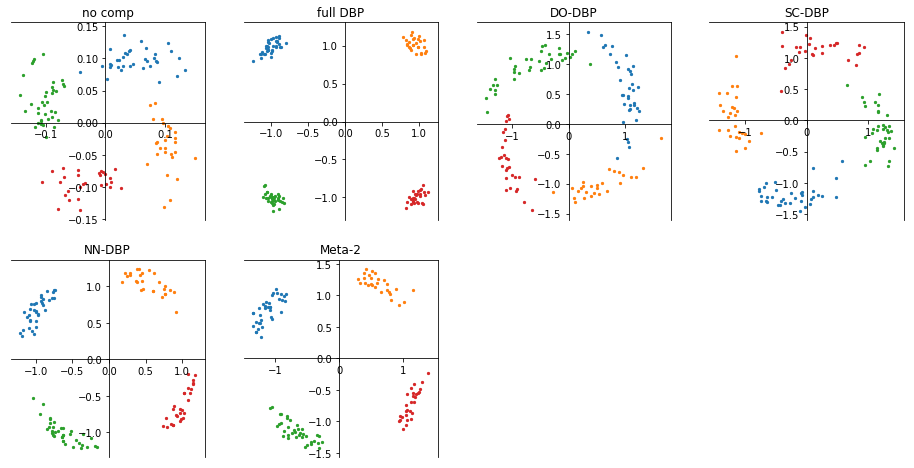

In [27]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import config
from Transmitter import Tx
from Receiver import  Rx
from Fiber import Fiber
from train_model import test_model
config.symbol_rate = 10

############################ setting parameters ############################
test_power = 49
model_path = 'ckpt-set/ckpt-test-S10/'                              # 提取模型的路径
fig_path =  '/Users/xinyu/Desktop/WDM_Code/report/img/expriment/'  # 储存结果的路径

############################ Initializing the system ############################
k = 1
tx = Tx()
rx = Rx()
tx.set_power([test_power]*3)
rx.set_power([test_power]*3)
fiber = Fiber(tx.lam_set,length=1e5,alphaB=0.2,n2=2.7e-20,disp=17,dz=1e2,Nch=config.Nch,generate_noise=True)
comp = {}
z = {}
I = {}

############################ load model     ############################
# train_model_names = ['NN-DBP', 'Meta-1','Meta-2','Meta-3']       # 4 models
train_model_names = ['NN-DBP','Meta-2']
simple_model_names = ['DO-DBP', 'SC-DBP']                        # 2 models
comp['DO-DBP'] = Fiber(tx.lam_set[k:k+1], length=1e5, alphaB=-0.2, n2=0, disp=-17, dz=1e5, Nch=1)
comp['SC-DBP'] = Fiber(tx.lam_set[k:k+1], length=1e5, alphaB=-0.2, n2=-2.7e-20, disp=-17, dz=1e2, Nch=1)
comp['full DBP'] = Fiber(tx.lam_set, length=1e5, alphaB=-0.2, n2=-2.7e-20, disp=-17, dz=1e3, Nch=config.Nch)

for name in train_model_names:
    comp[name] = torch.load(model_path + name + '_best.pt',map_location=torch.device('cpu'))['model']

############################ simulation and testing    ############################

'''               communication system structure
    ----------------------         -------------          ----------                
x --|      (1)Fiber        |-- y --|  (2)DBP     |-- z --| (3)Filter | --- I --- (4) show constellation
     ----------------------         -------------          ---------
'''

# (1) Fiber
x, symbol_stream, bit_stream = tx.wdm_signal_sample()
y = fiber(x)

# (2) DBP
z['full DBP'] = comp['full DBP'](y)[k]
z['no comp'] = y[k]
for name in simple_model_names + train_model_names:
    z[name] = comp[name](y[k:k+1])[0]

# (3) Filter 
for name in ['no comp', 'full DBP'] + simple_model_names + train_model_names:
    I[name] = rx.filter(z[name], Nch=k)

# (4) show constellation
plt.figure(figsize=(16,8))
for i,name in enumerate(['no comp', 'full DBP'] + simple_model_names + train_model_names):
    plt.subplot(241+i)
    rx.show_symbol(I[name], symbol_stream[k])
    plt.title(name)
#plt.savefig(fig_path + f'W120-D3-P{power}'+'star.png')

In [28]:
# 计算BER
acc = {}
for name in simple_model_names + train_model_names:
    acc[name] = test_model(fiber, comp[name], tx,rx,N=100,power=50)

for key in acc.keys():
    print('%10s  &   %g \\\\' % (key, acc[key]))



    DO-DBP  &   0.340273 \\
    SC-DBP  &   0.40707 \\
    NN-DBP  &   0.999766 \\
    Meta-2  &   1 \\


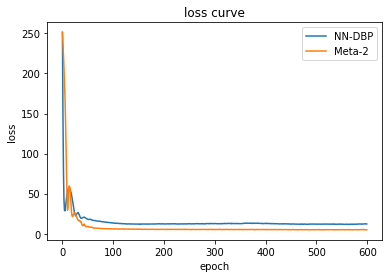

In [22]:
# plot loss curve
loss = {}
power=50
#for name in train_model_names:
for name in train_model_names:
    loss[name] = torch.load(model_path + name + '_losspath.pt')['train loss']
    plt.plot(loss[name],label=name)

plt.legend(loc='best')
plt.title('loss curve')
plt.xlabel('epoch')
plt.ylabel('loss')
#plt.savefig(fig_path + f'W120-D3-P{power}'+'loss.png')

In [24]:
comp['Meta-2']

Fiber(
  (H_trained): ModuleList(
    (0): FNN(
      (fc0): complex_linear()
      (net): ModuleList(
        (0): complex_linear()
        (1): complex_linear()
        (2): complex_linear()
      )
      (fc1): complex_linear()
    )
    (1): FNN(
      (fc0): complex_linear()
      (net): ModuleList(
        (0): complex_linear()
        (1): complex_linear()
        (2): complex_linear()
      )
      (fc1): complex_linear()
    )
    (2): FNN(
      (fc0): complex_linear()
      (net): ModuleList(
        (0): complex_linear()
        (1): complex_linear()
        (2): complex_linear()
      )
      (fc1): complex_linear()
    )
    (3): FNN(
      (fc0): complex_linear()
      (net): ModuleList(
        (0): complex_linear()
        (1): complex_linear()
        (2): complex_linear()
      )
      (fc1): complex_linear()
    )
    (4): FNN(
      (fc0): complex_linear()
      (net): ModuleList(
        (0): complex_linear()
        (1): complex_linear()
        (2): complex_line

In [ ]:
## 待办事项
'''
**1. 可视化参数，看到底是那部分起作用
2. 加宽，加深 网络，或者改变网络架构 （Transformer）
3. 数据增广， 看泛化
4. 学习率策略: 0.001

width: 20,60,100
depth: 2,3,4
power: [50,50], [50,60]
'''

'''
1. meta net 结构调整
(1) complex CNN
(2) complex RNN,Transformer  加入历史信息 S = phi(u_i, u_{i-1})

2.noise term
n  -->  n * u

3. channel num, 16 QAM

'''

'\n**1. 可视化参数，看到底是那部分起作用\n2. 加宽，加深 网络，或者改变网络架构 （Transformer）\n3. 数据增广， 看泛化\n4. 学习率策略: 0.001\n\nwidth: 20,60,100\ndepth: 2,3,4\npower: [50,50], [50,60]\n'

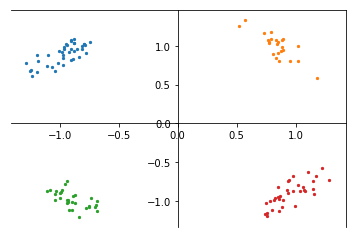

In [ ]:
'''
'scale', 'plus', 'scale+plus' 为什么会相同的loss曲线
'''
fiber = Fiber(tx.lam_set,length=1e5,alphaB=0.2,n2=2.7e-20,disp=17,dz=100,Nch=config.Nch,generate_noise=True,noise_level=1e-3)
dsp = Fiber(tx.lam_set,length=1e5,alphaB=-0.2,n2=-2.7e-20,disp=-17,dz=200,Nch=config.Nch)
x,s,_ = tx.wdm_signal_sample()

z = x
for i in range(10):
    y = fiber(z)
    z = dsp(y)
I = rx.filter(z[0],Nch=1)
rx.show_symbol(I,s[0])

In [22]:
from complex_layers import FNN
import torch
net = FNN(10,10)

In [9]:
from Transmitter import Tx
import matplotlib.pyplot as plt
tx = Tx()

In [16]:
x,_,_=tx.wdm_signal_sample()

/Users/xinyu/opt/anaconda3/envs/jpter/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


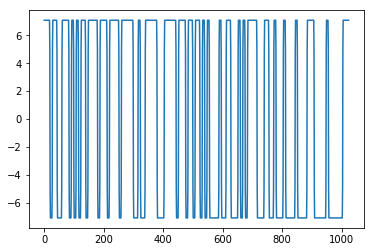

In [19]:
plt.plot(x[0])

In [3]:
import config
import numpy as np

In [18]:
path = 'data/'
os.system(f'cp config.py ckpt-set/config.py')

0

SyntaxError: invalid syntax (3788835062.py, line 1)